In [ ]:
!nvidia-smi
from google.colab import files

files.upload()

!pip install --ignore-installed --upgrade kaggle
! mkdir ~ /.kaggle
! cp kaggle.json ~ /.kaggle /
! chmod 600 ~ /.kaggle / kaggle.json
!kaggle competitions download -c petfinder-pawpularity-score
!unzip petfinder-pawpularity-score.zip
!kaggle datasets download -d mithilsalunkhe / no-dupes-rice-fold
!unzip no-dupes-rice-fold.zip
!kaggle datasets download -d phalanx / petfinder2-cropped-dataset
!unzip petfinder2-cropped-dataset.zip
!kaggle datasets download -d mithilsalunkhe / pseudo-with-old-comp
!mkdir pseudo
!unzip / content / pseudo-with-old-comp.zip -d pseudo

!pip install -qq timm
!pip install -U git+https: // github.com / albu / albumentations --no-cache-dir -qqq

!pip uninstall opencv_python_headless

!pip install opencv-python-headless == 4.5.4.60
!pip install -qq albumentations == 1.0.3
!pip install -qq grad-cam
!pip install -qq ttach
!pip install -qq scikit-learn == 0.24.0
!pip install -qq fastai
!pip install -qq fastai --upgrade

In [ ]:
!unzip no-dupes-rice-fold.zip


In [ ]:
import sys
from timm import create_model

from timm.data.mixup import Mixup

from fastai.vision.all import *
#from fastai.callback.hook import *

: 

In [ ]:
set_seed(365, reproducible=True)
BATCH_SIZE = 8
NEED_TRAIN = True

In [ ]:
"""clean_dataset_path = Path('../input/petfinder-pawpularity-score-clean/')
clean_dataset_path.ls()

dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

train_df = pd.read_csv(clean_dataset_path/'train.csv')

train_df['path'] = train_df['Id'].map(lambda x:str(clean_dataset_path/'train'/x)+'.jpg')"""
train_df = pd.read_csv('/content/train_10folds.csv')
dataset_path = Path('/content/train')
train_df['path'] = train_df['Id'].map(lambda x: str(dataset_path / x) + '.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True)  #shuffle dataframe
train_df.head()

In [ ]:
len_df = len(train_df)
print(f"There are {len_df} images")

train_df['Pawpularity'].hist(figsize=(10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

In [ ]:
train_df['norm_score'] = train_df['Pawpularity'] / 100
train_df['norm_score']


In [ ]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
	os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [ ]:
seed = 365
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [ ]:
"""#Sturges' rule
num_bins = int(np.floor(1+np.log2(len(train_df))))
num_bins

train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

train_df[train_df['fold']==0].head()

train_df[train_df['fold']==0]['bins'].value_counts()

train_df[train_df['fold']==1]['bins'].value_counts()"""

In [ ]:
def petfinder_rmse(input, target):
	return 100 * torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [ ]:
import logging
import random
import albumentations

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image
from audioop import bias
from albumentations.core.transforms_interface import NoOp

logger = logging.getLogger(__name__)

PARAMETER_MAX = 10
RESAMPLE_MODE = None


def AutoContrast(img, **kwarg):
	return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
	v = _float_parameter(v, max_v) + bias
	return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
	v = _float_parameter(v, max_v) + bias
	return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
	v = _float_parameter(v, max_v) + bias
	return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, **kwarg):
	if v == 0:
		return img
	v = _float_parameter(v, max_v)
	v = int(v * min(img.size))
	w, h = img.size
	x0 = np.random.uniform(0, w)
	y0 = np.random.uniform(0, h)
	x0 = int(max(0, x0 - v / 2.))
	y0 = int(max(0, y0 - v / 2.))
	x1 = int(min(w, x0 + v))
	y1 = int(min(h, y0 + v))
	xy = (x0, y0, x1, y1)
	# gray
	color = (127, 127, 127)
	img = img.copy()
	PIL.ImageDraw.Draw(img).rectangle(xy, color)
	return img


def CutoutConst(img, v, max_v, **kwarg):
	v = _int_parameter(v, max_v)
	w, h = img.size
	x0 = np.random.uniform(0, w)
	y0 = np.random.uniform(0, h)
	x0 = int(max(0, x0 - v / 2.))
	y0 = int(max(0, y0 - v / 2.))
	x1 = int(min(w, x0 + v))
	y1 = int(min(h, y0 + v))
	xy = (x0, y0, x1, y1)
	# gray
	color = (127, 127, 127)
	img = img.copy()
	PIL.ImageDraw.Draw(img).rectangle(xy, color)
	return img


def Equalize(img, **kwarg):
	return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
	return img


def Invert(img, **kwarg):
	return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias, **kwarg):
	v = _int_parameter(v, max_v) + bias
	return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, **kwarg):
	v = _float_parameter(v, max_v)
	if random.random() < 0.5:
		v = -v
	return img.rotate(v)


def Sharpness(img, v, max_v, bias):
	v = _float_parameter(v, max_v) + bias
	return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, **kwarg):
	v = _float_parameter(v, max_v)
	if random.random() < 0.5:
		v = -v
	return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0), RESAMPLE_MODE)


def ShearY(img, v, max_v, **kwarg):
	v = _float_parameter(v, max_v)
	if random.random() < 0.5:
		v = -v
	return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0), RESAMPLE_MODE)


def Solarize(img, v, max_v, **kwarg):
	v = _int_parameter(v, max_v)
	return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, threshold=128, **kwarg):
	v = _int_parameter(v, max_v)
	if random.random() < 0.5:
		v = -v
	img_np = np.array(img).astype(np.int)
	img_np = img_np + v
	img_np = np.clip(img_np, 0, 255)
	img_np = img_np.astype(np.uint8)
	img = Image.fromarray(img_np)
	return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, **kwarg):
	v = _float_parameter(v, max_v)
	if random.random() < 0.5:
		v = -v
	v = int(v * img.size[0])
	return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0), RESAMPLE_MODE)


def TranslateY(img, v, max_v, **kwarg):
	v = _float_parameter(v, max_v)
	if random.random() < 0.5:
		v = -v
	v = int(v * img.size[1])
	return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v), RESAMPLE_MODE)


def TranslateXConst(img, v, max_v, **kwarg):
	v = _float_parameter(v, max_v)
	if random.random() > 0.5:
		v = -v
	return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0), RESAMPLE_MODE)


def TranslateYConst(img, v, max_v, **kwarg):
	v = _float_parameter(v, max_v)
	if random.random() > 0.5:
		v = -v
	return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v), RESAMPLE_MODE)


def _float_parameter(v, max_v):
	return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
	return int(v * max_v / PARAMETER_MAX)


def rand_augment_pool():
	augs = [(AutoContrast, None, None),
	        (Brightness, 1.8, 0.1),
	        (Color, 1.8, 0.1),
	        (Contrast, 1.8, 0.1),
	        (Equalize, None, None),
	        (Invert, None, None),
	        (Posterize, 4, 0),
	        (Rotate, 45, None),
	        (Sharpness, 1.8, 0.1),
	        (ShearX, 0.3, None),
	        (ShearY, 0.3, None),
	        (Solarize, 256, None),
	        (TranslateXConst, 100, None),
	        (TranslateYConst, 100, None),
	        ]
	return augs


class RandAugment(object):
	def __init__(self, n, m, resample_mode=PIL.Image.BILINEAR):
		assert n >= 1
		assert m >= 1
		global RESAMPLE_MODE
		RESAMPLE_MODE = resample_mode
		self.n = n
		self.m = m
		self.augment_pool = rand_augment_pool()

	def __call__(self, img):
		ops = random.choices(self.augment_pool, k=self.n)
		for op, max_v, bias in ops:
			prob = np.random.uniform(0.2, 0.8)
			if random.random() + prob >= 1:
				img = op(img, v=self.m, max_v=max_v, bias=bias)
		return img


Rand = RandAugment(n=4, m=6)


class RandAlbumentaion(NoOp):
	def apply(self, img, **params):
		return Rand(Image.fromarray(img))




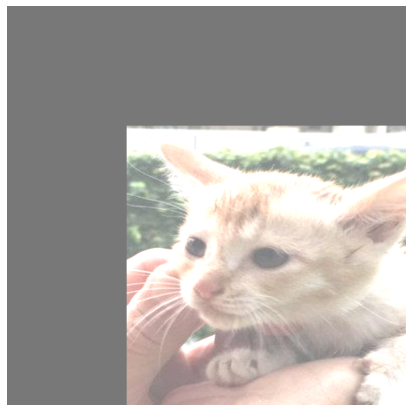

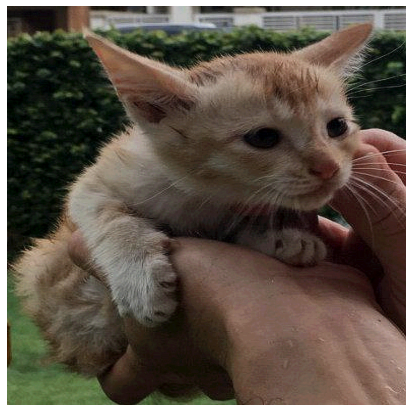

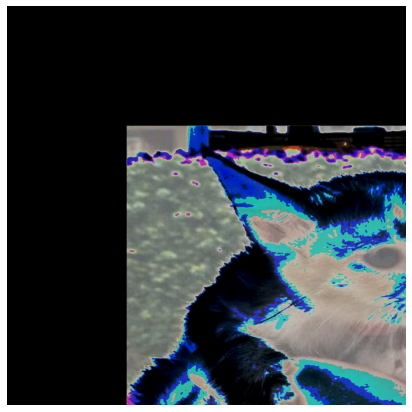

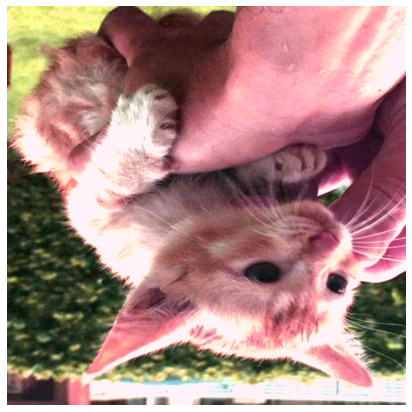

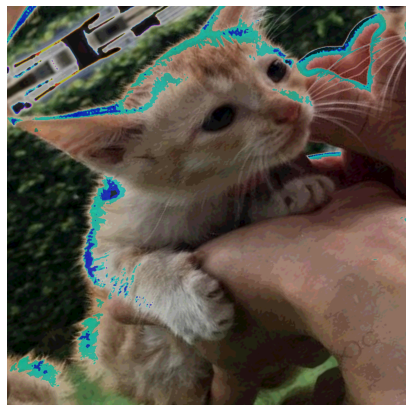

In [11]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A


def visualize(image):
	plt.figure(figsize=(10, 10))
	plt.axis('off')
	plt.imshow(image)


image = cv2.imread(r'F:\Pycharm_projects\PetFinder\data\train\0a0da090aa9f0342444a7df4dc250c66.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def train_aug():
	return A.Compose([
		A.Resize(1024, 1024),
		A.SomeOf([A.RandomContrast((0.9, 0.3)), A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=15),
		          A.RandomBrightness(limit=[0.9, 0.3]), A.Flip(), A.Rotate(limit=45), A.Equalize(), A.Sharpen(),
		          A.Solarize(196), A.Posterize(), A.Affine(translate_percent=[0.3, 0.3])], n=3)
	])


def valid_aug():
	return A.Compose([
		A.Resize(1024, 1024),

	])


class AlbumentationsTransform(RandTransform):
	"A transform handler for multiple `Albumentation` transforms"
	split_idx, order = None, 2

	def __init__(self, train_aug, valid_aug):
		store_attr()

	def before_call(self, b, split_idx):
		self.idx = split_idx

	def encodes(self, img: PILImage):
		if self.idx == 0:
			aug_img = self.train_aug(image=np.array(img))['image']
		else:
			aug_img = self.valid_aug(image=np.array(img))['image']
		return PILImage.create(aug_img)

In [ ]:




def get_data(fold):
	#     train_df_no_val = train_df.query(f'fold != {fold}')
	#     train_df_val = train_df.query(f'fold == {fold}')

	#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
	train_df_f = train_df.copy()
	# add is_valid for validation fold
	train_df_f['is_valid'] = (train_df_f['kfold'] == fold)

	#mixup_fn = Mixup(**mixup_args)

	#     dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
	# #                                valid_pct=0.2, #80-20 train-validation random split
	#                                valid_col='is_valid', #
	#                                seed=999, #seed
	#                                fn_col='path', #filename/path is in the second column of the DataFrame
	#                                label_col='norm_score', #label is in the first column of the DataFrame
	#                                y_block=RegressionBlock, #The type of target
	#                                bs=BATCH_SIZE, #pass in batch size
	#                                num_workers=8,
	#                                item_tfms=Resize(224), #pass in item_tfms
	#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
	# It looks if seed of RandomSplitter is set, it reduce the score. So we don't set seed here
	#splitter = RandomSplitter(0.2)
	# Change RandomSplitter to IndexSplitter
	#splitter = IndexSplitter(splitter(range(len(train_df)))[1])
	val_idx = train_df_f[train_df_f['is_valid']].index.values

	dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
	                get_x=ColReader('path'),
	                get_y=ColReader('norm_score'),
	                splitter=IndexSplitter(val_idx),
	                item_tfms=[Resize(384),AlbumentationsTransform(train_aug(), valid_aug())],  #pass in item_tfms
	                )

	paw_dls = dls.dataloaders(train_df_f,
	                          bs=BATCH_SIZE,
	                          num_workers=8,
	                          seed=seed)

	return paw_dls  #, splitter


In [ ]:
"""mixup_args = {
             'mixup_alpha': 1.,
             'cutmix_alpha': 0.,
             'cutmix_minmax': None,
             'prob': 1.0,
             'switch_prob': 0.,
             'mode': 'batch',
             'label_smoothing': 0,
             'num_classes': 1}"""

In [ ]:
def get_learner(fold_num):
	data = get_data(fold_num)

	model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

	learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse),
	                cbs=[MixUp(0.4)]).to_fp16()

	return learn  #, splitter

In [ ]:
"""
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

if len(test_df) != 8:
    NEED_TRAIN = True"""

"""test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])"""
train_df['norm_score'] = train_df['Pawpularity'] / 100

import gc

from sklearn.metrics import mean_squared_error

folds = [0, 1, 2, 3, 4]
if NEED_TRAIN:
	rmse_list = []
	#train_df['oof'] = -1

	for i in folds:
		print(f'Fold {i} results')
		train = train_df[train_df['kfold'] != i]
		valid =

		learn = get_learner(fold_num=i)

		#         mixup_args = {
		#             'mixup_alpha': 1.,
		#             'cutmix_alpha': 0.,
		#             'cutmix_minmax': None,
		#             'prob': 1.0,
		#             'switch_prob': 0.,
		#             'mode': 'batch',
		#             'label_smoothing': 0,
		#             'num_classes': 100}

		#         mixup_fn = Mixup(**mixup_args)

		learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(),
		                                  EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)])

		learn.recorder.plot_loss()

		#over fitting
		#         learn.unfreeze()

		#         learn.fit_one_cycle(5,lr_max=slice(1e-6,1e-4))

		learn = learn.to_fp32()

		learn.export(f'model_fold_{i}.pkl')

		#all_preds.append(preds)

		val_idx = train_df[train_df['kfold'] == i].index
		val_df = train_df.loc[val_idx]

		"""dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('path'),
                get_y=ColReader('norm_score'),
                #splitter=IndexSplitter(val_idx),
                item_tfms=Resize(224), #pass in item_tfms
                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation(), Flip(), Rotate(max_deg=45)])
               )
    
        paw_dls = dls.dataloaders(train_df, 
                          bs=BATCH_SIZE,
                          num_workers=8,
                          seed=seed)"""

		val_pred, _ = learn.get_preds()
		val_pred = val_pred.numpy()
		val_pred = val_pred * 100

		train_df.loc[val_idx, 'oof'] = val_pred
		print('Pawpularity vs OOF')
		print(val_df['Pawpularity'][:5], val_pred[:5])

		real_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['Pawpularity'],
		                               train_df[train_df['kfold'] == i]['oof'], squared=False)

		fold_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['oof'],
		                               train_df[train_df['kfold'] == i]['Pawpularity'], squared=False)
		print(f'Fold {i} RMSE: {fold_rmse}')
		rmse_list.append(fold_rmse)

		"""
        #val_idx = splitter(range(len(train_df)))[1]
        train_df.loc[train_df[train_df['kfold'] == i].index, 'oof'] = oof_preds
        real_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['Pawpularity'], 
                    train_df[train_df['kfold'] == i]['oof'], squared=False)
        rmse_list.append(real_rmse)
        print(f'real_rmse: {real_rmse:0.5f}')
        
        val_df = train_df.loc[val_idx]
        val_pred, _ = learn.tta(dl=paw_dls.test_dl(val_df), n=5, beta=0)
        print(val_df['Pawpularity'][:5], val_pred[:5])
        score = mean_squared_error(val_df['Pawpularity'], val_pred*100, squared=False)
        print(f'Fold {i} | Score: {score}')
        # Save prediction of validation as pred
        train_df.loc[val_idx, 'pred'] = val_pred*100"""

		del learn

		torch.cuda.empty_cache()

		gc.collect()

print(f'Average Fold RMSE: {sum(rmse_list) / len(rmse_list)}')

In [ ]:
train_df[['oof', 'Pawpularity']].plot.scatter('oof', 'Pawpularity')

In [ ]:
train_df[['oof', 'Pawpularity']].hist()

In [ ]:
train_df.to_csv('train_with_oof.csv')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!cp -r / content / model_fold_0.pkl / content / model_fold_1.pkl / content / model_fold_2.pkl / content / model_fold_3.pkl / content / model_fold_4.pkl / content / drive / MyDrive / models / Swinlarge224Fastai10kf